The problem I set to solve was 
Given a user, a time/datestamp, and pickup location, predict where they will be asked to dropped off.  I began with some exploratory analysis of the data.

# Exploratory Data Analysis

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor 
%matplotlib inline

In [2]:
df = pd.read_csv("../data/hw1_train.csv")
df.head(5)

,begintrip_at,begintrip_lat,begintrip_lng,dropoff_lat,dropoff_lng,uid
0,2015-02-14_00:51:48,36.1700,-86.7431,36.1620,-86.7018,160
1,2015-02-07_01:52:35,36.1739,-86.6750,36.1641,-86.6706,7ac
2,2015-02-06_03:19:48,36.1633,-86.7742,36.1577,-86.7581,22e
3,2015-02-22_03:35:01,36.1678,-86.7020,36.1789,-86.6744,688
4,2015-02-01_19:45:18,36.1652,-86.7006,36.1553,-86.7104,e0a


In [4]:
df.describe()

,begintrip_lat,begintrip_lng,dropoff_lat,dropoff_lng
count,11000.000000,11000.000000,11000.000000,11000.000000
mean,36.169234,-86.712052,36.169436,-86.712488
std,0.010337,0.030859,0.010210,0.031051
min,36.148000,-86.804500,36.148000,-86.803100
25%,36.162500,-86.737600,36.163200,-86.739500
50%,36.168500,-86.706900,36.168700,-86.707300
75%,36.176300,-86.686600,36.176100,-86.686700
max,36.201900,-86.640200,36.202000,-86.640100


So we note that the data file consists of data from 11,000 tax trips in Nashville, Tennessee.  

In [5]:
df['uid'].value_counts()

4ee    41
fbe    31
230    30
488    29
9ae    26
3a8    26
43e    24
fc4    24
c18    24
0ca    24
5e0    23
108    22
4b6    22
2a4    21
07e    21
...
f0e    1
10e    1
4ca    1
b34    1
984    1
05a    1
05e    1
704    1
170    1
cac    1
392    1
cc4    1
7cc    1
6bc    1
9d0    1
Length: 1893, dtype: int64

In [12]:
uid_data=df['uid'].value_counts()
print "number of unique riders: {}".format(len(uid_data))
#True counts represent drivers who have only taken one trip
print (uid_data==1).value_counts()
print (uid_data==2).value_counts()
print (uid_data <=4).value_counts()
print "mean trips per rider: {}".format(uid_data.mean())
print "Standard deviation of trips per rider: {}".format(uid_data.std())

number of unique riders: 1893
False    1722
True      171
dtype: int64
False    1650
True      243
dtype: int64
False    998
True     895
dtype: int64
mean trips per rider: 5.81088219757
Standard deviation of trips per rider: 4.23205675153


More specifically, we note that there are 1893 distinct riders. In our data set, each rider has taken an average of 5.81 trips (with standard deviation of 4.23).  We note that 171 riders have taken only 1 trip, an additional 243 have taken only 2 trips, and 895 have taken 4 or less trips.  For this reason it might be difficult to build a model around the uid because we lack sufficient data for many of the riders to learn their riding patterns.

Next we make a scatter plot of the drop-off locations to see how clustered the drop off spots are.

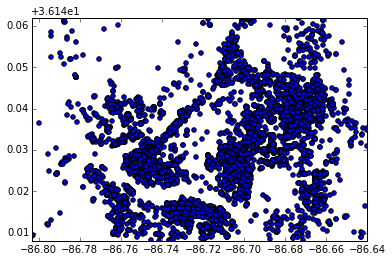

In [13]:
x = df["dropoff_lng"]
y = df["dropoff_lat"]
fig, ax = plt.subplots()
ax.set_xlim([x.min(),x.max()])
ax.set_ylim([y.min(),y.max()])
ax.scatter(x=x,y=y)

We might imagine that most trips involve pick-up and drop-off at landmarks in the city, which we might try to identify by clustering the pick-up and drop-off locations.  

I decided to use mean-shift clustering because this does not require us to know the number of clusters in advance.

In [15]:
points = np.hstack((x.reshape(-1,1),y.reshape(-1,1)))
bandwidth = estimate_bandwidth(points, quantile=0.005)
ms = MeanShift(bandwidth=bandwidth,bin_seeding=True)
ms.fit(points)
labels = ms.labels_
cluster_centers = ms.cluster_centers_
labels_unique = np.unique(labels)
n_clusters = len(labels_unique)

print "We fit a mean-shift clustering object that results in {} clusters".format(n_clusters)

We fit a mean-shift clustering object that results in 257 clusters


Next we plot the cluster centers on top off the drop off locations to get a sense of how closely our cluster centers cover the drop-off location data

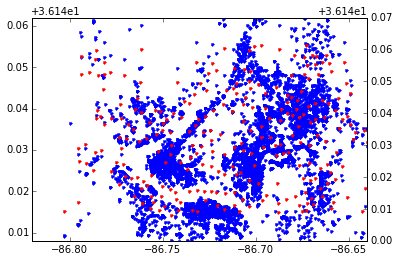

In [16]:
fig,ax1=plt.subplots()
ax1.plot(x,y,'b.')
ax1.set_xlim([x.min(),x.max()])
ax1.set_ylim([y.min(),y.max()])
ax2=ax1.twinx()
ax2.plot(cluster_centers[:,0], cluster_centers[:,1], 'r.')
plt.show()

As an example, we select user 4ee who has the most trips on our data set with 41.  We then get counts of his trips to see which clusters the rider frequents and the counts.  Below the left column corresponds to the cluster label and the right column how often the passenger was dropped off at that spot.

In [17]:
df["dropoff_class"] = ms.labels_
user_4ee =df[df['uid']=="4ee"]
label_counts = user_4ee['dropoff_class'].value_counts()
print label_counts

57    9
25    5
8     5
34    4
29    3
39    2
32    2
18    2
5     2
62    1
46    1
28    1
22    1
17    1
9     1
6     1
dtype: int64


In [18]:
print cluster_centers[57]

[-86.67138222  36.17015333]



The cluster center appears to be located at
2660 Old Lebanon Rd
Nashville, Tennessee
and might correspond to a salon or a motel.

#Baseline Models

Next to get an idea for how challenging of a data set we're dealing with we run a few baseline models.  This also helps to set some benchmarks when trying to assess the performance of our real models.
The metric we use to judge the model performance is out of sample R-squared.

First, we run a simple multiple regression that predicts 
**("dropoff_lat","dropoff_lng")** from **("begintrip_lat","begintrip_lng")**.

We first read in the test data, which also requires some preliminary cleaning.

In [20]:
def clean_data(df):
    numeric_cols=['begintrip_lat', 'begintrip_lng','dropoff_lat','dropoff_lng']
    for col in numeric_cols:
        df[col] = df[col].convert_objects(convert_numeric=True)
    old_len = df.shape[0]
    df.dropna(axis=0,inplace=True)
    df = df.reset_index()
    new_len = df.shape[0]
    print "Dropped {} rows with NaN".format(old_len-new_len)
    return df

In [21]:
df_test = pd.read_csv("../data/hw1_test.csv")
df_test=clean_data(df_test)

Dropped 1 rows with NaN


In [23]:
features=["begintrip_lat","begintrip_lng"]
labels=["dropoff_lat","dropoff_lng"]
X_train = df[features].as_matrix()
y_train=df[labels].as_matrix()
LR = LinearRegression()
LR.fit(X=X_train,y=y_train)

LinearRegression(copy_X=True, fit_intercept=True, normalize=False)

In [29]:
X_test=df_test[features].as_matrix()
y_test=df_test[labels].as_matrix()
r_squared = LR.score(X=X_test,y=y_test)
print "The out-of-sample r-squared for linear regression: {}".format(r_squared)

The out-of-sample r-squared for linear regression: 0.173675185713


Next we train a random-forest regressor using the same input features and target.

In [27]:
RF = RandomForestRegressor(n_estimators=100,criterion="mse")
RF.fit(X=X_train,y=y_train)
r_squared = RF.score(X=X_test,y=y_test)
print "The out of sample r-squared for the random forest regressor: {}".format(r_squared)

The out of sample r-squared for the random forest regressor: 0.0401994611596


We can see the baseline linear regression has some predictive power, while the random forest  doesn't perform much better than simply guessing the mean.

# Summary of methods

The majority of my time I spent developing on coding a framework for feature engineering.  As much as possible, I attempted to stay within an object oriented framework to make my code as clean as possible and to make it easily extendible and flexible for conducting experiments.  

For basic features, from the time of pick up I extracted the day of the week (as an integer 0 through 6) and the hour of the day.

For more involved features I used historical statistics features which are described [here](http://blogs.technet.com/b/machinelearning/archive/2015/02/17/big-learning-made-easy-with-counts.aspx).

More specifically, I clustered the start locations and the drop-off locations.  Then for each start location label, I computed the counts from the training data of how many trips that started at this label finished in each of the drop-off cluster labels.  Then I fed these vectors in as features for a random forest model regressor.  
 
With just these features, the random forest achieved on the test set an out-of-sample r-squared of around **.195**.  This is better than the basline models, but not appreciably so.  The features however do show promise because they improved the baseline random forest model by **.19**.

I attempted to feed in the raw start-location coordinates and hour of the day/ day of the week features into the model, but the out of sample r-squared dropped to close to 0.  I think the proper approach would be to incorporate these features by themselves in a separate model and to ensemble them with count features.

I also attempted to tackle the problem as a classification instead of a regression problem.  A similar approach was used in a recent Kaggle competition that also involved predicting taxi drop-off locations.  An explanation of the winner's methods can be found [here](http://blog.kaggle.com/2015/07/27/taxi-trajectory-winners-interview-1st-place-team-🚕/).

The basic idea is to use the labels of the drop-off location cluster centers as the categorical target variable.  Then the drop off location is computed by computing the expected drop off location found by averaging the drop-off cluster locations with respect to the predicted target probabilities returned by the random forest.

The results for this model were not good (highly negative out-of-sample r-squared). which lead me to believe I have a bug in my code. 
Given more time I would trouble shoot this part of the code.



# Explanation of code base

My code base consists of the following files:

- **PreprocessData.py**.  This is a module that handled the preprocessing of the train and test data.  Here is where I load and clean the train and test data.  Also here is where the basic features and count features are implemented.  This code can be easily modified to adjust the features of the model.  The PreprocessData module contains as attributes the train and test dataframes and feature and label matrices that can be loaded by the model.

- **LocationClusters.py**  This module contains a class controlling the mean-shift clustering of the start and drop-off locations.

- **CountFeatures.py**  This module contains a class to implement historical count features using an two categorical features: an input and output feature.  That is it computes counts of the classes for output for each class of input.  The code is designed to be general so that we can implement it for a variety of features and experiment to find which are most flexible.

- **train_and_score_models.py**  This script contains the code to build and score a model and then pickle it.  It loads the data by using PreprocessData.py.  Then in a few short lines a model can be built around the data stored by the PreprocessData object.

- **predict.py** This script loads the model saved by train_and_score_models.py and reads in a test file from command line and records the out of sample R-squared for that test set.  (This file needs to be improved so it doesn't have to repeat code from the other files).

# Future Work

Given more time, I would experiment more with the historical count features. For instance, to learn from individual rider patterns, I would similarly do counts based on user id, and also counts based on the day of the week and the hour of the day.  

I would first attempt build a single model on all of these features and then ensemble several models each built on the different set of historical statistic features.  In addition to random forests, I would also like to experiment with gradient boosted trees and neural networks.

Also, I would attempt to fine tune the parameters of the model (the number of trees, the weights of the ensemble, the number of clusters, etc.) by running n-fold cross-validation on the training set.  

In terms of my code, given more time I would trouble shoot the Random forest classificier.  Also I would implement comprehensive test cases for all the modules I wrote.  I would add a configuration file to configure all the parameters used in the model so that it could scale well as I add more features and files.  Also, I would divide the logic for the PreProcessData class into a class for train data and a class for test data to make the code more modular.